# Importación de bibliotecas

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import tree

# Preprocesamiento
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

# Configuración warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Cross validation
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score

# Modelo red neuronal
import tensorflow as tf
from tensorflow import keras

# Carga de datos y pasos previos al entrenamiento

Importamos el dataset filtrado para comenzar a trabajar

In [2]:
ds_hotel=pd.read_csv('./hotels_train_filtrado3.csv')
ds_trabajo = ds_hotel.copy()

Aplicamos One-Hot Encoding para trabajar con las variables categóricas antes de entrenar nuestros modelos

In [3]:
# ONE HOT ENCODING ...
ds_trabajo_encoded = pd.get_dummies(ds_trabajo, columns=['hotel',
                                                 'market_segment',
                                                 'distribution_channel',
                                                 'is_repeated_guest',
                                                 'deposit_type',
                                                 'customer_type',
                                                 'agent_specified',
                                                 'more_than_zero_days_in_waiting_list',
                                                 'season',
                                                 'region',
                                                 'room_type_match'], drop_first=True)
ds_trabajo_encoded.head()

,lead_time,stays_in_weekend_nights,stays_in_week_nights,previous_cancellations,previous_bookings_not_canceled,booking_changes,adr,total_of_special_requests,is_canceled,arrival_date,...,agent_specified_1,more_than_zero_days_in_waiting_list_1,season_Spring,season_Summer,season_Winter,region_Americas,region_Asia,region_Europe,region_Oceania,room_type_match_True
0,1.633333,1.0,2.0,0.0,0,0,115.5,1,1,1.473034e+09,...,1,0,0,1,0,1,0,0,0,1
1,0.133333,0.0,1.0,0.0,0,0,42.0,0,0,1.446250e+09,...,0,0,0,0,0,0,0,1,0,1
2,0.833333,0.0,1.0,0.0,0,0,229.0,2,0,1.476317e+09,...,1,0,0,0,0,0,0,1,0,1
3,0.866667,2.0,5.0,0.0,0,0,75.0,0,1,1.481501e+09,...,1,0,0,0,0,0,0,1,0,1
4,3.466667,2.0,5.0,0.0,0,0,75.0,1,0,1.489882e+09,...,1,0,0,0,1,0,0,1,0,1


In [4]:
ds_trabajo_encoded.columns

Index(['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'booking_changes', 'adr', 'total_of_special_requests', 'is_canceled',
       'arrival_date', 'total_guests', 'hotel_Resort Hotel',
       'market_segment_Groups', 'market_segment_Offline TA/TO',
       'market_segment_Online TA', 'market_segment_Others',
       'distribution_channel_Direct', 'distribution_channel_GDS',
       'distribution_channel_TA/TO', 'is_repeated_guest_1',
       'deposit_type_Non Refund', 'customer_type_Transient',
       'customer_type_Transient-Party', 'agent_specified_1',
       'more_than_zero_days_in_waiting_list_1', 'season_Spring',
       'season_Summer', 'season_Winter', 'region_Americas', 'region_Asia',
       'region_Europe', 'region_Oceania', 'room_type_match_True'],
      dtype='object')

Generamos el código para mostrar las métricas y la matriz de confusión de nuestras predicciones 

In [5]:
def mostrar_metricas(y_test, y_pred):
  print(classification_report(y_test,y_pred))

  # Calcular las métricas de evaluación
  accuracy = accuracy_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)

  # Imprimir las métricas de evaluación
  print("Accuracy:", accuracy)
  print("Recall:", recall)
  print("Precision:", precision)
  print("f1 score:", f1)

  cm = confusion_matrix(y_test,y_pred)
  sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')

Como Keras no tiene una métrica F1 score predefinida para  utilizar al momento de compilar redes neuronales, vamos a definir una función externa a la biblioteca que calcula el F1 score, basándonos en la implementación que se muestra en [este artículo](https://aakashgoel12.medium.com/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d).

In [6]:
import keras.backend as K
def get_f1(y_true, y_pred): # taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

# Modelo de Redes Neuronales

Vamos a normalizar los datos para que todas las características tengan una escala similar y no dominen unas sobre otras durante el entrenamiento de nuestras redes neuronales y para mejorar su rendimiento. Lo aplicamos luego de hacer la división train-test con proporción 70/30.

In [8]:
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# Creo un dataset con los features que voy a usar para clasificar
ds_trabajo_x = ds_trabajo_encoded.drop(['is_canceled'], axis='columns')

# Creo un dataset con la variable target
ds_trabajo_y = ds_trabajo_encoded['is_canceled'].copy()

# Genero los conjuntos de train y de test
x_train, x_test, y_train, y_test = train_test_split(ds_trabajo_x,
                                                    ds_trabajo_y, 
                                                    test_size=0.3,
                                                    random_state=2)

# Armo una versión estandarizada
stand_scaler = preprocessing.StandardScaler()
x_train_norm = pd.DataFrame(stand_scaler.fit_transform(x_train), columns=x_train.columns)
x_test_norm = pd.DataFrame(stand_scaler.transform(x_test), columns=x_test.columns)


Y establecemos una semilla para lograr que los resultados sean reproducibles.

In [9]:
# Establecer una semilla
seed_value = 2
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

## Modelo 1: capa de entrada, capa de salida, optimizador SGD

Observamos que nuestra red neuronal tendrá 32 neuronas de entrada y dos clases para la salida.

In [ ]:
# Cantidad de clases de salida
cant_clases=len(np.unique(y_train))
# Cantidad de columnas de entrada
d_in=len(x_train_norm.columns)

print(f"Cantidad de neuronas de entrada: {d_in}")
print(f"Cantidad de clases de salida: {cant_clases}")

Cantidad de neuronas de entrada: 32
Cantidad de clases de salida: 2


Vamos a empezar entrenando una red neuronal densa simple que sólo tenga dos capas. La capa de entrada tendrá 32 neuronas (cantidad de columnas en nuestro dataset) y la de salida sólo 1 (por ser clasificación binaria). Usaremos la función sigmoide como función de activación para este modelo.

In [ ]:
modelo_rn_1 = keras.Sequential([
    keras.layers.Dense(1, activation='sigmoid', input_shape=(d_in,))
])

modelo_rn_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________


Compilamos el modelo. Vamos a usar el optimizador SGD con learning rate de 0.01 y la función de pérdida binary_crossentropy. La métrica a evaluar en el modelo será F1 score.

In [ ]:
modelo_rn_1.compile(
  optimizer=keras.optimizers.SGD(learning_rate=0.01), 
  loss='binary_crossentropy', 
  metrics=[get_f1], 
)

Y lo entrenamos. Vamos a definir un batch size de 32 y 12 épocas. Por lo tanto, se dividirán las 43336 muestras del dataset de train en lotes de 32 muestras, para cada una de las 12 épocas, resultando así 43336/32 = 1355 lotes por época (la implementación redondea la división hacia arriba). Dado que estamos usando SGD, que actualiza pesos después de cada lote procesado, se actualizarán los pesos 1355 veces por época, siendo así 1355*12 = 16260 actualizaciones en el entrenamiento total.

In [ ]:
modelo_rn_1.fit(x_train_norm, y_train, batch_size=32, epochs=12, validation_data=(x_test_norm, y_test))

Epoch 1/12
1355/1355 [==============================] - 3s 2ms/step - loss: 0.5327 - get_f1: 0.7134 - val_loss: 0.4914 - val_get_f1: 0.7390
Epoch 2/12
1355/1355 [==============================] - 2s 2ms/step - loss: 0.4846 - get_f1: 0.7372 - val_loss: 0.4831 - val_get_f1: 0.7412
Epoch 3/12
1355/1355 [==============================] - 2s 2ms/step - loss: 0.4790 - get_f1: 0.7403 - val_loss: 0.4797 - val_get_f1: 0.7436
Epoch 4/12
1355/1355 [==============================] - 2s 2ms/step - loss: 0.4763 - get_f1: 0.7417 - val_loss: 0.4773 - val_get_f1: 0.7460
Epoch 5/12
1355/1355 [==============================] - 2s 2ms/step - loss: 0.4745 - get_f1: 0.7445 - val_loss: 0.4759 - val_get_f1: 0.7465
Epoch 6/12
1355/1355 [==============================] - 2s 2ms/step - loss: 0.4731 - get_f1: 0.7439 - val_loss: 0.4748 - val_get_f1: 0.7478
Epoch 7/12
1355/1355 [==============================] - 2s 2ms/step - loss: 0.4721 - get_f1: 0.7465 - val_loss: 0.4741 - val_get_f1: 0.7461
Epoch 8/12
1355/1355

Hacemos la predicción, convirtiendo las salidas continuas en predicciones binarias utilizando un umbral. Dado que creemos que es importante reducir los falsos negativos en el problema de predecir el estado de cancelación de reservas (es decir, queremos minimizar la clasificación incorrecta de reservas que en realidad serían canceladas, vamos a definir este umbral por debajo de 0.5, siendo así el modelo más permisivo al clasificar las reservas como canceladas. Analizamos las métricas obtenidas para distintos valores del umbral y observamos que con 0.4 mantenemos un recall y un f1 score similares. 

581/581 [==============================] - 1s 904us/step
              precision    recall  f1-score   support

           0       0.76      0.75      0.75      9195
           1       0.76      0.76      0.76      9378

    accuracy                           0.76     18573
   macro avg       0.76      0.76      0.76     18573
weighted avg       0.76      0.76      0.76     18573

Accuracy: 0.7569051849458892
Recall: 0.7644487097462146
Precision: 0.756622691292876
f1 score: 0.7605155678141411


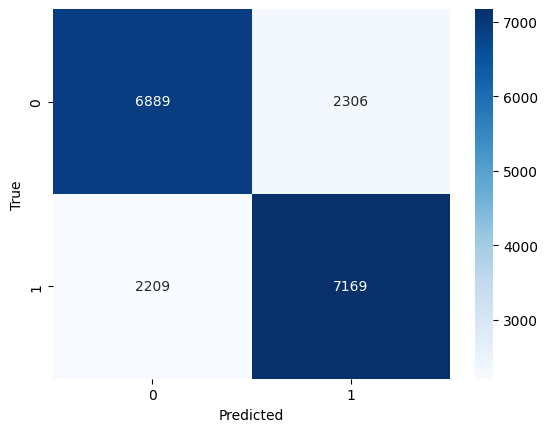

In [ ]:
y_pred_norm = modelo_rn_1.predict(x_test_norm)
y_pred = np.where(y_pred_norm > 0.45, 1, 0)
mostrar_metricas(y_test, y_pred)

Obtuvimos métricas decentes con este modelo de red neuronal simple. Vamos a entrenar más modelos con arquitecturas distintas para lograr mejorar estas métricas e intentar llevarlas a valores superiores a los obtenidos con modelos anteriores.

## Modelos 2 y 3: una capa oculta, optimizador Adam

Para nuestra segunda iteración, a la arquitectura de nuestra red neuronal densa le vamos a agregar una capa oculta con 20 neuronas y usará la función de activación ReLu. Para la capa de salida, usaremos la sigmoidea. 

In [ ]:
modelo_rn_2 = keras.Sequential([
    keras.layers.Dense(32, activation='relu', input_shape=(d_in,)),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

Esta vez vamos a compilar con el optimizador Adam y un learning rate de 0.001. Nuevamente vamos a elegir optimizar F1 score.

In [ ]:
modelo_rn_2.compile(
  optimizer=keras.optimizers.Adam(learning_rate=0.001), 
  loss='binary_crossentropy', 
  metrics=[get_f1], 
)

Lo entrenamos con un batch size de 35 y 30 épocas.

In [ ]:
modelo_rn_2.fit(x_train_norm, y_train, batch_size=35, epochs=30, validation_data=(x_test_norm, y_test))

Epoch 1/30
1239/1239 [==============================] - 3s 2ms/step - loss: 0.4692 - get_f1: 0.7426 - val_loss: 0.4379 - val_get_f1: 0.7662
Epoch 2/30
1239/1239 [==============================] - 2s 2ms/step - loss: 0.4306 - get_f1: 0.7695 - val_loss: 0.4289 - val_get_f1: 0.7778
Epoch 3/30
1239/1239 [==============================] - 2s 2ms/step - loss: 0.4195 - get_f1: 0.7787 - val_loss: 0.4198 - val_get_f1: 0.7800
Epoch 4/30
1239/1239 [==============================] - 2s 2ms/step - loss: 0.4128 - get_f1: 0.7817 - val_loss: 0.4162 - val_get_f1: 0.7871
Epoch 5/30
1239/1239 [==============================] - 2s 2ms/step - loss: 0.4075 - get_f1: 0.7862 - val_loss: 0.4137 - val_get_f1: 0.7850
Epoch 6/30
1239/1239 [==============================] - 2s 2ms/step - loss: 0.4040 - get_f1: 0.7890 - val_loss: 0.4119 - val_get_f1: 0.7827
Epoch 7/30
1239/1239 [==============================] - 2s 2ms/step - loss: 0.4006 - get_f1: 0.7910 - val_loss: 0.4101 - val_get_f1: 0.7955
Epoch 8/30
1239/1239

Observamos que se logra mejorar todas las métricas con esta nueva arquitectura. Agregar una capa oculta y modificar ligeramente otros valores resultó en que el modelo aprenda relaciones más complejas entre los datos.

581/581 [==============================] - 1s 981us/step
              precision    recall  f1-score   support

           0       0.80      0.81      0.80      9195
           1       0.81      0.80      0.80      9378

    accuracy                           0.80     18573
   macro avg       0.80      0.80      0.80     18573
weighted avg       0.80      0.80      0.80     18573

Accuracy: 0.8046088407903946
Recall: 0.7955854126679462
Precision: 0.8133653112395073
f1 score: 0.8043771225270875


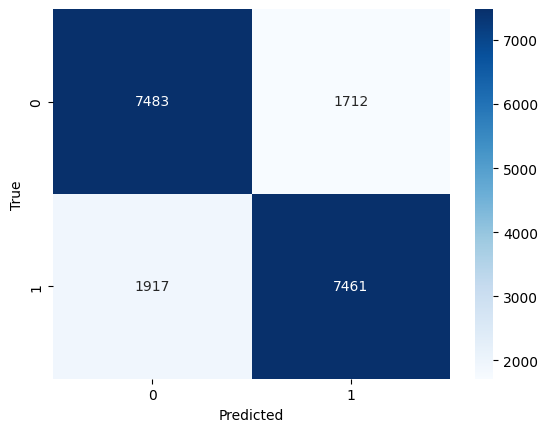

In [ ]:
y_pred_norm = modelo_rn_2.predict(x_test_norm)
y_pred = np.where(y_pred_norm > 0.45, 1, 0)
mostrar_metricas(y_test, y_pred)

Exportamos este primer red neuronal con métricas por encima de 80% en formato pickle

In [ ]:
import pickle

with open('models/rn/rn1_model.pickle', 'wb') as archivo:
    pickle.dump(modelo_rn_2, archivo)

Vamos a incrementar la cantidad de neuronas para que el modelo pueda aprender más patrones.

In [ ]:
modelo_rn_3 = keras.Sequential([
    keras.layers.Dense(250, activation='relu', input_shape=(d_in,)),
    keras.layers.Dense(150, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
modelo_rn_3.compile(
  optimizer=keras.optimizers.Adam(learning_rate=0.001), 
  loss='binary_crossentropy', 
  metrics=[get_f1], 
)

Entrenaremos la red neuronal y analizaremos cómo evoluciona el modelo a través de las épocas a partir de un gráfico.

In [ ]:
history_modelo_rn_3 = modelo_rn_3.fit(x_train_norm, y_train, batch_size=64, epochs=100, validation_data=(x_test_norm, y_test))

Epoch 1/100
678/678 [==============================] - 3s 3ms/step - loss: 0.4456 - get_f1: 0.7631 - val_loss: 0.4239 - val_get_f1: 0.7798
Epoch 2/100
678/678 [==============================] - 2s 3ms/step - loss: 0.4140 - get_f1: 0.7819 - val_loss: 0.4165 - val_get_f1: 0.7879
Epoch 3/100
678/678 [==============================] - 2s 3ms/step - loss: 0.4016 - get_f1: 0.7924 - val_loss: 0.4029 - val_get_f1: 0.7929
Epoch 4/100
678/678 [==============================] - 2s 3ms/step - loss: 0.3945 - get_f1: 0.7975 - val_loss: 0.4000 - val_get_f1: 0.7969
Epoch 5/100
678/678 [==============================] - 2s 3ms/step - loss: 0.3874 - get_f1: 0.8011 - val_loss: 0.3987 - val_get_f1: 0.7999
Epoch 6/100
678/678 [==============================] - 2s 3ms/step - loss: 0.3815 - get_f1: 0.8061 - val_loss: 0.3988 - val_get_f1: 0.7932
Epoch 7/100
678/678 [==============================] - 2s 3ms/step - loss: 0.3778 - get_f1: 0.8067 - val_loss: 0.3942 - val_get_f1: 0.8063
Epoch 8/100
678/678 [======

581/581 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.81      0.78      0.80      9195
           1       0.80      0.82      0.81      9378

    accuracy                           0.80     18573
   macro avg       0.80      0.80      0.80     18573
weighted avg       0.80      0.80      0.80     18573

Accuracy: 0.8033704840359662
Recall: 0.8226700789080827
Precision: 0.795032976092333
f1 score: 0.8086154491143486


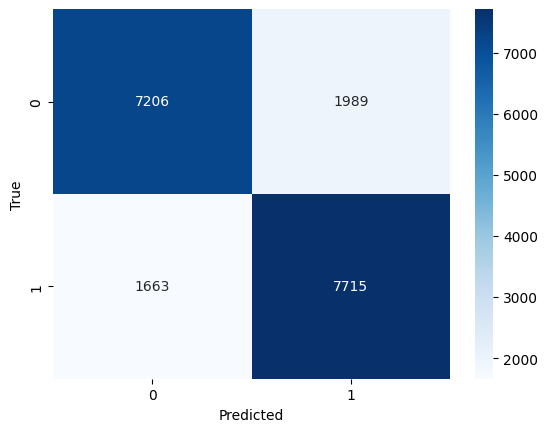

In [ ]:
y_pred_norm = modelo_rn_3.predict(x_test_norm)
y_pred = np.where(y_pred_norm > 0.45, 1, 0)
mostrar_metricas(y_test, y_pred)

Analizando los gráficos de `get_f1` y `val_get_f1` (métrica en el conjunto de entrenamiento y métrica en el conjunto de validación respectivamente), podemos ver que, mientras en entrenamiento llega a métricas del 92%, en validación no supera el 81% aproximadamente. Esto se traduce en un problema de overfitting. Vemos que la red neuronal obtiene muy buen F1 score en entrenamiento, pero la métrica baja significativamente en validación. Esto es una clara señal de que el modelo tiene una alta varianza y está sobreajustando. 

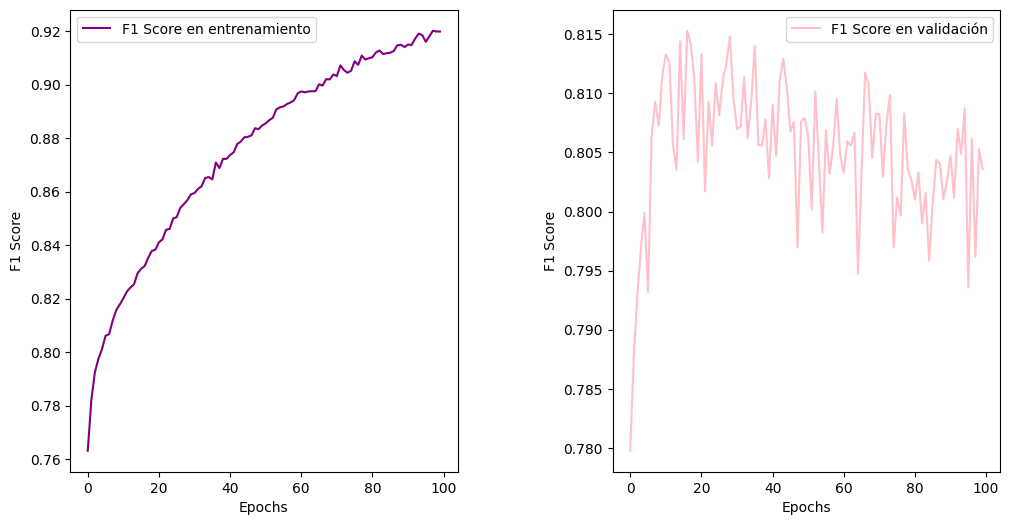

In [ ]:
import matplotlib.pyplot as plt
epochs = range(100)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Graficar el F1 score en el primer subplot
ax1.plot(epochs, history_modelo_rn_3.history['get_f1'], color='purple', label='F1 Score en entrenamiento')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("F1 Score")
ax1.legend()

# Graficar el historial del entrenamiento (loss) en el segundo subplot
ax2.plot(epochs, history_modelo_rn_3.history['val_get_f1'], color='pink', label='F1 Score en validación')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("F1 Score")
ax2.legend()

# Ajustar los espacios entre subplots
plt.subplots_adjust(wspace=0.4)

# Mostrar la figura
plt.show()

Intentaremos solucionar este problema aplicando técnicas de regularización (como Early Stopping reduciendo las épocas cuando no notemos mejora y aplicando L2 en algunas capas) a los próximos modelos, para limitar la complejidad de nuestro modelo y evitar el overfitting.

## Modelo 4: dos capas ocultas, optimizador Nadam, parámetro de regularización L2

Este modelo tendrá 2 capas ocultas y una cantidad de neuronas mayor en cada una. Esta vez, vamos a introducir un parámetro de regularización L2 en una capa oculta para evitar este sobreajuste analizado en el apartado anterior.

In [ ]:
modelo_rn_4 = keras.Sequential([
    keras.layers.Dense(420, activation='relu', input_shape=(d_in,)),
    keras.layers.Dense(264, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

Compilaremos con el optimizador Nadam y un learning rate de 0.001.

In [ ]:
modelo_rn_4.compile(
  optimizer=keras.optimizers.Nadam(learning_rate=0.001), 
  loss='binary_crossentropy', 
  metrics=[get_f1], 
)

También aplicaremos Early Stopping al disminuir la cantidad de épocas de entrenamiento a 80.

In [ ]:
history_modelo_rn_4 = modelo_rn_4.fit(x_train_norm, y_train, batch_size=32, epochs=80, validation_data=(x_test_norm, y_test))

Epoch 1/80
1355/1355 [==============================] - 10s 6ms/step - loss: 0.5151 - get_f1: 0.7590 - val_loss: 0.4558 - val_get_f1: 0.7442
Epoch 2/80
1355/1355 [==============================] - 7s 5ms/step - loss: 0.4316 - get_f1: 0.7759 - val_loss: 0.4309 - val_get_f1: 0.7833
Epoch 3/80
1355/1355 [==============================] - 7s 5ms/step - loss: 0.4184 - get_f1: 0.7857 - val_loss: 0.4185 - val_get_f1: 0.7899
Epoch 4/80
1355/1355 [==============================] - 7s 5ms/step - loss: 0.4113 - get_f1: 0.7900 - val_loss: 0.4131 - val_get_f1: 0.7923
Epoch 5/80
1355/1355 [==============================] - 7s 5ms/step - loss: 0.4063 - get_f1: 0.7926 - val_loss: 0.4196 - val_get_f1: 0.7887
Epoch 6/80
1355/1355 [==============================] - 7s 5ms/step - loss: 0.4024 - get_f1: 0.7953 - val_loss: 0.4140 - val_get_f1: 0.7869
Epoch 7/80
1355/1355 [==============================] - 7s 5ms/step - loss: 0.3996 - get_f1: 0.7965 - val_loss: 0.4063 - val_get_f1: 0.7940
Epoch 8/80
1355/135

Vamos a observar cómo evoluciona el modelo a través de las épocas habiendo incrementado la cantidad de capas ligeramente y luego de introducir regularización.

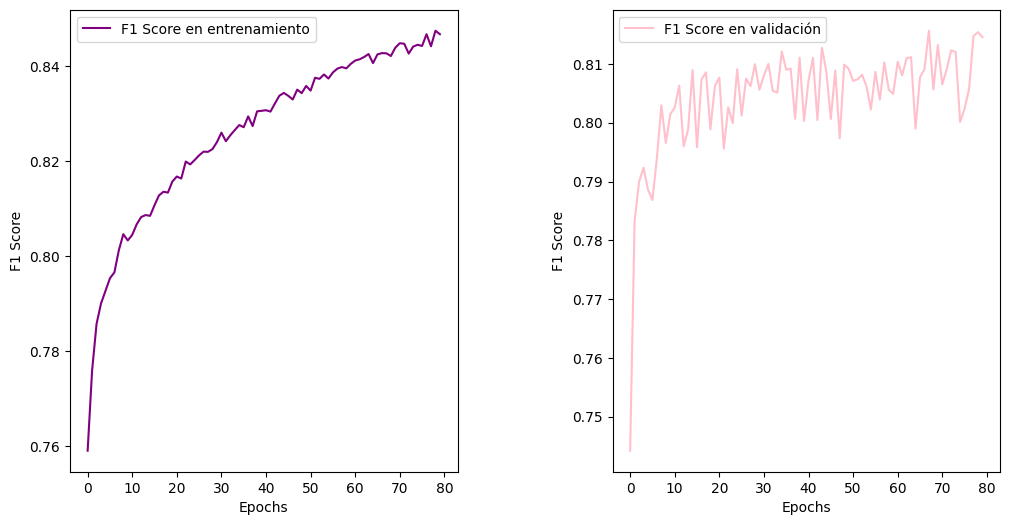

In [ ]:
import matplotlib.pyplot as plt
epochs = range(80)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Graficar el F1 score en el primer subplot
ax1.plot(epochs, history_modelo_rn_4.history['get_f1'], color='purple', label='F1 Score en entrenamiento')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("F1 Score")
ax1.legend()

# Graficar el historial del entrenamiento (loss) en el segundo subplot
ax2.plot(epochs, history_modelo_rn_4.history['val_get_f1'], color='pink', label='F1 Score en validación')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("F1 Score")
ax2.legend()

# Ajustar los espacios entre subplots
plt.subplots_adjust(wspace=0.4)

# Mostrar la figura
plt.show()

Podemos observar que, gracias a la regularización, ahora no se produce overfitting (hay diferencia de aproximadamente 3 puntos porcentuales entre el score de entrenamiento y el de test). Obtuvimos ahora una métrica F1 score de 82% aproximadamente.

581/581 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.82      0.80      0.81      9195
           1       0.81      0.83      0.82      9378

    accuracy                           0.81     18573
   macro avg       0.81      0.81      0.81     18573
weighted avg       0.81      0.81      0.81     18573

Accuracy: 0.8143003284337479
Recall: 0.8331200682448283
Precision: 0.8057131071465402
f1 score: 0.8191874180865006


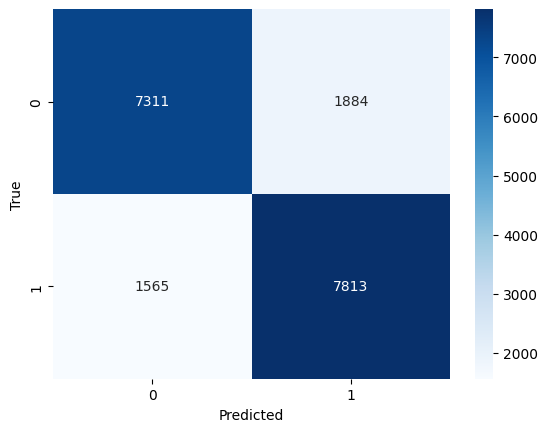

In [ ]:
y_pred_norm = modelo_rn_4.predict(x_test_norm)
y_pred = np.where(y_pred_norm > 0.5, 1, 0)
mostrar_metricas(y_test, y_pred)

## Modelo 5: optimizador Nesterov


Entrenamos una red neuronal densa simple que sólo tenga dos capas. La capa de entrada tendrá 32 neuronas (cantidad de columnas en nuestro dataset) y la de salida sólo 1 (por ser clasificación binaria). Usaremos la función sigmoid como función de activación para este modelo.

In [32]:
modelo_rn_5= keras.Sequential([
    keras.layers.Dense(1,input_shape=(d_in,), activation='sigmoid',kernel_initializer='uniform')])

modelo_rn_5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________


Compilamos el modelo. Vamos a usar el optimizador SGD con learning rate de 0.01, momentum de 0.2 y nesterov = True, y la función de pérdida binary_crossentropy. La métrica a evaluar en el modelo será F1 score.

In [61]:
modelo_rn_5.compile(
  optimizer=keras.optimizers.SGD(learning_rate=0.01,momentum = 0.7, nesterov = True), 
  loss='binary_crossentropy', 
  metrics=[get_f1], 
)

Entrenamos el modelo

In [67]:
modelo_rn_5.fit(x_train_norm, y_train, batch_size=32, epochs=12, validation_data=(x_test_norm, y_test))

Epoch 1/12
1355/1355 [==============================] - 3s 2ms/step - loss: 0.4678 - get_f1: 0.7516 - val_loss: 0.4688 - val_get_f1: 0.7525
Epoch 2/12
1355/1355 [==============================] - 3s 2ms/step - loss: 0.4676 - get_f1: 0.7494 - val_loss: 0.4694 - val_get_f1: 0.7532
Epoch 3/12
1355/1355 [==============================] - 3s 2ms/step - loss: 0.4676 - get_f1: 0.7509 - val_loss: 0.4688 - val_get_f1: 0.7505
Epoch 4/12
1355/1355 [==============================] - 3s 3ms/step - loss: 0.4678 - get_f1: 0.7501 - val_loss: 0.4686 - val_get_f1: 0.7521
Epoch 5/12
1355/1355 [==============================] - 3s 2ms/step - loss: 0.4677 - get_f1: 0.7517 - val_loss: 0.4688 - val_get_f1: 0.7551
Epoch 6/12
1355/1355 [==============================] - 3s 2ms/step - loss: 0.4677 - get_f1: 0.7505 - val_loss: 0.4690 - val_get_f1: 0.7515
Epoch 7/12
1355/1355 [==============================] - 3s 2ms/step - loss: 0.4675 - get_f1: 0.7501 - val_loss: 0.4698 - val_get_f1: 0.7478
Epoch 8/12
1355/1355

Hacemos la predicción, convirtiendo las salidas continuas en predicciones binarias utilizando un umbral.

581/581 [==============================] - 1s 1ms/step
              precision    recall  f1-score   support

           0       0.74      0.83      0.78      9195
           1       0.81      0.71      0.76      9378

    accuracy                           0.77     18573
   macro avg       0.77      0.77      0.77     18573
weighted avg       0.77      0.77      0.77     18573

Accuracy: 0.7703655844505465
Recall: 0.7142247814032843
Precision: 0.8086442110346492
f1 score: 0.7585074457844969


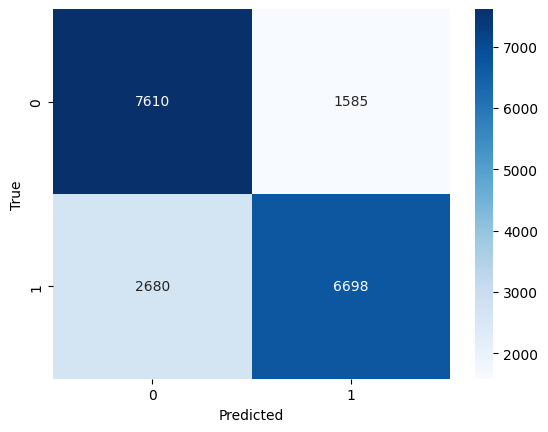

In [68]:
y_pred_norm = modelo_rn_5.predict(x_test_norm)
y_pred = np.where(y_pred_norm > 0.5, 1, 0)
mostrar_metricas(y_test, y_pred)